## Import

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import spacy


from tqdm import tqdm

from millenlp.preprocessing import PreProc
from millenlp.embeddings import FastTextVec, TfidfVec
from millenlp.state_models.shallow_model import ShallowModel

from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.manifold import TSNE
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from graphviz import Digraph

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric
from gensim.corpora import WikiCorpus
from gensim.models import FastText

/opt/conda/envs/nlp/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## function definitions

In [2]:
def ranking_by_label_prediction(data_set,model,label):
    data_set['Prediction'] = data_set['iteration'].apply(lambda x : model._classifier.predict(model._vectorizer.transform([model.preprocessing(x)]))[0])
    data_set[model._classifier.classes_] = pd.DataFrame(data_set['iteration'].apply(lambda x : model._classifier.predict_proba(model._vectorizer.transform([model.preprocessing(x)]))[0]).values.tolist(), 
                                                                                index= data_set.index)
    return data_set.sort_values([label], ascending = [0])

def vocabulary(model, label_to_sort):
    
    if 'FastText' is model._vectorizer._embedding.__class__.__name__:
        classes = model._classifier.classes_
        word_dict = list(model._vectorizer._embedding.wv.vocab.keys())

        features_words = pd.DataFrame(model._vectorizer.transform(word_dict), 
                                      columns = list(range(model._vectorizer._num_features)))
        features_words = features_words.astype(float)

        features_ranked = pd.DataFrame(word_dict, columns = ['feature'])
        for i, label in enumerate(classes):
            topics = [label_to_sort] if len(model._classifier.classes_) < 3 else model._classifier.classes_.tolist()
            ranking_dim = pd.DataFrame(np.transpose(model._classifier.coef_), columns=topics)
            ranking_dim['feature'] = list(range(model._vectorizer._num_features))
            ranking_dim = ranking_dim.round(2).sort_values(label_to_sort, ascending=False).reset_index(drop=True)
            ranking_dim = ranking_dim[ranking_dim[model._classifier.classes_].idxmax(axis=1)==label]

            feature_weight = pd.DataFrame()
            features_words_filtered = features_words[ranking_dim.feature.tolist()]
            feature_weight[label] = np.dot(features_words_filtered.values,
                                           ranking_dim[label_to_sort].values) / features_words_filtered.shape[1]
            features_ranked = pd.concat([features_ranked,feature_weight], axis = 1)

        features_ranked = features_ranked.sort_values(by=[label_to_sort], ascending = False)
        
    elif 'TfidfVectorizer' is model._vectorizer._embedding.__class__.__name__:
        
        topics = [label_to_sort] if len(model._classifier.classes_) < 3 else model._classifier.classes_.tolist()
#         topics = model._classifier.classes_.tolist()
        features_ranked = pd.DataFrame(np.transpose(model._classifier.coef_), columns=topics)
        features_ranked['feature'] = model._vectorizer._embedding.get_feature_names()
        features_ranked = features_ranked.round(2).sort_values(label_to_sort, ascending=False).reset_index(drop=True)
        
    return features_ranked

def node_coef(data_set,coef_features,msg_col,label_col,feature,per_class):
    if per_class:
        data_set = data_set[data_set.label == label_col]
    count_feature = data_set[data_set[msg_col].str.contains(feature)].shape[0]
    if feature in coef_features.feature.values:
        coef = coef_features[coef_features.feature.isin([feature])][label_col].values[0]
    else:
        coef = 'Not in Dict'
    feature_info = pd.DataFrame(np.array([[feature,count_feature,round(coef,2)]]),
                                      columns = ['feature','counts','coef'])
    return feature_info 

def prob_around_word(data_set,coef_features,regex,msg_col,label_col, feature, per_class):
    
    if per_class:
        data_set = data_set[data_set.label == label_col]
        
    regex = regex.replace('{}',feature)
    look_around = data_set[msg_col].str.extract(regex, expand=False)
    count_feature = data_set[data_set[msg_col].str.contains(feature)].shape[0]
    
    if isinstance(look_around, pd.DataFrame):
        look_around = look_around.iloc[:,-1]
        
    look_around = look_around.dropna().value_counts().to_frame().reset_index()  
    look_around.columns = ['feature','counts']
    look_around['probability'] = np.divide(look_around.counts.values,np.sum(look_around.counts.values))*100
    look_around['coef'] = [round(coef_features[coef_features.feature.isin([word])][label_col].values[0],2)
                           if word in coef_features.feature.values else 'Not in Dict' 
                           for word in look_around.feature.values]
    return look_around

def left_parents(data_set, child, graph, dot):
    for parent in data_set.feature.values:
        data = data_set[data_set.feature==parent]
        if parent in list(graph.keys()):
            graph[parent][child] = (data.probability.values[0],
                                    data.counts.values[0],
                                    data.coef.values[0])
            dot = set_graph_atr(dot, data.coef.values[0])
            dot.node(parent,'{} \n Count = {} \n Coef = {}'.format(parent,
                                                                   data.counts.values[0],
                                                                   data.coef.values[0]),
                    shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(data.probability.values[0],2)))),weight='1.2')
        else:
            graph[parent] = {child: (data.probability.values[0],
                                     data.counts.values[0],
                                     data.coef.values[0])}
            dot = set_graph_atr(dot, data.coef.values[0])
            dot.node(parent,'{} \n Count = {} \n Coef = {}'.format(parent,
                                                                   data.counts.values[0],
                                                                   data.coef.values[0]),
                    shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(data.probability.values[0],2)))),weight='1.2')
    return graph, dot

def right_child(data_set, parent, graph,dot):
    if parent in list(graph.keys()):
        graph[parent] = {**graph[parent],**dict(zip(data_set.feature.values,
                                                   zip(data_set.probability.values,
                                                       data_set.counts.values,
                                                      data_set.coef.values)))}
        for child, counts, prob, coef in data_set.values:
            dot = set_graph_atr(dot, coef)
            dot.node(child,'{} \n Count = {} \n Coef = {}'.format(child,
                                                                  counts,
                                                                  coef),shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(prob,2)))),weight='1.2')
        
    else:
        graph[parent] = dict(zip(data_set.feature.values,
                               zip(data_set.probability.values,
                                   data_set.counts.values,
                                   data_set.coef.values)))
        for child, counts, prob, coef in data_set.values:
            dot = set_graph_atr(dot, coef)
            dot.node(child,'{} \n Count = {} \n Coef = {}'.format(child,
                                                                  counts,
                                                                  coef),shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(prob,2)))),weight='1.2')
    return graph, dot

def set_graph_atr(dot, coef):
    if isinstance(coef,str):
        dot.attr('node',style='filled', color='lightgrey')
    else:
        if coef > 0:
            dot.attr('node',style='filled', color='green')
        elif coef <= 0:
            dot.attr('node', style='filled', color='red')
    return dot

def create_adjacency_graph(data_set,model,label,num_features,per_class,levels):

    coef_vocab = vocabulary(model,label)
    features = coef_vocab.feature.iloc[:num_features+1].values.tolist()
    feature = features[num_features]
    
    check_around = ['(\w+(?=(?:\s(?:\w+\s){level}){}))',
                    '(({}\s)(\s*(\w+)){0,level})']
    
    graph = {}
    dot = Digraph(comment='Data Feature Probability Relationship')
    feature_data = node_coef(data_set,coef_vocab,'iteration',label,feature,per_class)
    dot.attr('node',style='filled', color='blue')
    dot.node(feature_data.feature.values[0],'{} \n Count = {} \n Coef = {}'.format(feature_data.feature.values[0],
                                                                                   feature_data.counts.values[0],
                                                                                   feature_data.coef.values[0]))
    for side in range(levels):
        where_to_check = check_around[side].replace('level',str(side))
        for level in range(levels):
            words_lvl1 = prob_around_word(data_set,
                                          coef_vocab,
                                          where_to_check,
                                          'iteration',
                                          label,
                                          feature,
                                          per_class).query('probability>5')
            if not side and level == 0:
                graph, dot = left_parents(words_lvl1, feature, graph, dot)
            elif not side and level == 1:
                for word in words_lvl1.feature.values:
                    
                    words_lvl2 = prob_around_word(data_set,
                                                  coef_vocab,
                                                  where_to_check,
                                                  'iteration',
                                                  label,
                                                  word,
                                                  per_class).query('probability>5')
                    graph, dot = left_parents(words_lvl2, word, graph, dot)
            elif side and level == 0:   
                graph, dot = right_child(words_lvl1, feature, graph, dot)
            elif side and level == 1:
                for word in words_lvl1.feature.values:
                    words_lvl2 = prob_around_word(data_set,
                                                  coef_vocab,
                                                  where_to_check,
                                                  'iteration',
                                                  label,
                                                  word,
                                                  per_class).query('probability>5')
                    graph, dot = right_child(words_lvl2, word, graph, dot)
    return dot

def elbow_plot(features, clusters2test):
    
    clust = []
    final_distance = []
    l = features.shape[0]
    for cluster in range(2, clusters2test):
        clust = KMeans(cluster).fit_predict(features)
        distances_per_cl = []
        cluster_list = clust.tolist()
        weight = [cluster_list.count(cluster_num)/l for cluster_num in range(0, cluster)]
        for clu in range(cluster):
            centroide = features[np.where(clust == clu)[0],:].mean(axis = 0).reshape(1,-1)
            euc_distance = euclidean_distances(features[np.where(clust == clu)[0],:], centroide)
            distances_per_cl.append(euc_distance.mean())
            
        final_distance.append((np.array(distances_per_cl)@ weight)/len(distances_per_cl))
    
    plt.plot(list(range(2, clusters2test)),final_distance)
    
    return final_distance                                
                                
def plot_word_cloud(data, cluster):
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white",width=700, height=400).generate(data)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    wordcloud.to_file("wordclouds/{}.png".format(cluster))


In [3]:
# Options to display all the information inside the row
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
tqdm.pandas()
# Class PreProc
p = PreProc()
p._remove_digits = True
# p._stop_pos_words = []
# p._remove_names = False

/opt/conda/envs/nlp/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
data_base = pd.read_csv('/home/JhonChavez/clustering_codensa/data_emergencia.csv')
print (data_base.shape)

(113788, 9)


In [5]:
data_base[0:10]

product            sessionId  \
0  /voicebot_codensa_b2c  2-1578082323.601250   
1  /voicebot_codensa_b2c  1-1578082408.737052   
2  /voicebot_codensa_b2c  2-1578082580.601341   
3  /voicebot_codensa_b2c  2-1578082699.601374   
4  /voicebot_codensa_b2c  2-1578082796.601402   
5  /voicebot_codensa_b2c  2-1578082849.601415   
6  /voicebot_codensa_b2c  1-1578082867.737243   
7  /voicebot_codensa_b2c  2-1578082931.601438   
8  /voicebot_codensa_b2c  1-1578082985.737287   
9  /voicebot_codensa_b2c  1-1578083095.737341   

                                                                                                                                                                                                                                _text  \
0  no hay servicio                                                                                                                                                                                                                      
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor                                                                                                                        
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas                                                                                                              
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                                                                                                                                     
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos                                                                                                                      
5  no hay energia                                                                                                                                                                                                                       
6  problemas del servicio                                                                                                                                                                                                               
7  corte de luz                                                                                                                                                                                                                         
8  lo que pasa es que tengo un problema con la vaina de la energia que dice una casa y estoy esperando a ponerme las luces ya que los 20 dias Entonces eso es lo que pasa que no me explique no me digan que es lo que pasa sobre eso   
9  falla en el servicio                                                                                                                                                                                                                 

    templateId  id                              time         name      diff  \
0  emergencias  2   2020-01-03 15:13:10.036557-05:00  Emergencias  0.485171   
1  emergencias  8   2020-01-03 15:14:48.127871-05:00  Emergencias  0.259904   
2  emergencias  19  2020-01-03 15:17:50.659319-05:00  Emergencias  0.340897   
3  emergencias  30  2020-01-03 15:19:38.406214-05:00  Emergencias  0.255137   
4  emergencias  37  2020-01-03 15:21:22.117893-05:00  Emergencias  0.099053   
5  emergencias  43  2020-01-03 15:22:05.147743-05:00  Emergencias  0.428879   
6  emergencias  47  2020-01-03 15:22:30.122180-05:00  Emergencias  0.393107   
7  emergencias  52  2020-01-03 15:23:18.158533-05:00  Emergencias  0.397747   
8  emergencias  58  2020-01-03 15:24:22.121047-05:00  Emergencias  0.106807   
9  emergencias  76  2020-01-03 15:26:19.747221-05:00  Emergencias  0.682655   

         clase  
0  Emergencias  
1  Emerge

In [8]:
session = []
text = ''
df = pd.DataFrame()
for idx, data in enumerate(data_base['sessionId']):
    text = ''
    text += ' ' + str(data_base['_text'][data_base['sessionId'] == data])#.iloc[y])
    df = df.append({'Text' : text, 'Session': data}, ignore_index=True)
    if idx > 2000:
        break
df = df.drop_duplicates()

In [7]:
df[:10]

Session  \
0  2-1578082323.601250   
1  1-1578082408.737052   
2  2-1578082580.601341   
3  2-1578082699.601374   
4  2-1578082796.601402   
5  2-1578082849.601415   
6  1-1578082867.737243   
7  2-1578082931.601438   
8  1-1578082985.737287   
9  1-1578083095.737341   

                                                                                                                                                                                                                                                                   Text  
0   0    no hay servicio\nName: _text, dtype: object                                                                                                                                                                                                                     
1   1    escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor\nName: _text, dtype: object                                                                                                                       
2   2    estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas\nName: _text, dtype: object                                                                                                             
3   3    y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no\nName: _text, dtype: object                                                                                                                                    
4   4    hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos\nName: _text, dtype: object                                                                                                                     
5   5    no hay energia\nName: _text, dtype: object                                                                                                                                                                                                                      
6   6    problemas del servicio\nName: _text, dtype: object                                                                                                                                                                                                              
7   7    corte de luz\nName: _text, dtype: object                                                                                                                                                                                                                        
8   8    lo que pasa es que tengo un problema con la vaina de la energia que dice una casa y estoy esperando a ponerme las luces ya que los 20 dias Entonces eso es lo que pasa que no me explique no me digan que es lo que pasa sobre eso\nName: _text, dtype: object  
9   9    falla en el servicio\nName: _text, dtype: object

In [159]:
df['Text'] = df['Text'].str.replace('\n', '')
df['Text'] = df['Text'].str.replace('Name:', '')
df['Text'] = df['Text'].str.replace('_text,', '')
df['Text'] = df['Text'].str.replace('dtype:', '')
df['Text'] = df['Text'].str.replace('object', '')
df['Text'] = df['Text'].str.replace('\d+', '')

In [160]:
df['Text'] = df['Text'].str.replace('\nName: _text, dtype: object', '')
df['Text'] = df['Text'].str.replace('\d+', '')

In [161]:
df

Session  \
0     2-1578082323.601250   
1     1-1578082408.737052   
2     2-1578082580.601341   
3     2-1578082699.601374   
4     2-1578082796.601402   
5     2-1578082849.601415   
6     1-1578082867.737243   
7     2-1578082931.601438   
8     1-1578082985.737287   
9     1-1578083095.737341   
10    1-1578083117.737354   
11    1-1578083186.737395   
12    2-1578083255.601533   
13    2-1578083304.601545   
14    1-1578083322.737449   
15    2-1578083543.601622   
16    2-1578083570.601631   
17    1-1578083598.737579   
18    2-1578083632.601656   
19    2-1578083666.601670   
20    2-1578083782.601713   
21    2-1578083808.601723   
22    2-1578083817.601728   
23    1-1578083797.737657   
24    2-1578083847.601740   
25    1-1578083856.737680   
26    2-1578083895.601757   
27    2-1578083911.601765   
28    1-1578083947.737719   
29    1-1578083943.737714   
30    1-1578083962.737730   
31    2-1578084004.601801   
32    1-1578083988.737743   
33    1-1578084069.737765   
34    1-1578084090.737773   
35    2-1578084181.601872   
36    1-1578084241.737828   
37    2-1578084347.601940   
38    1-1578084346.737869   
39    2-1578084370.601950   
40    1-1578084419.737893   
41    1-1578084436.737901   
42    2-1578084473.601982   
43    1-1578084479.737920   
44    1-1578084549.737950   
45    2-1578084641.602043   
46    1-1578084778.738050   
47    1-1578084760.738038   
48    2-1578084829.602112   
49    2-1578084833.602116   
50    1-1578084842.738065   
51    2-1578084862.602121   
52    1-1578084901.738094   
53    2-1578085174.602240   
54    2-1578085274.602275   
55    2-1578085265.602273   
56    1-1578085312.738263   
57    1-1578085342.738281   
58    1-1578085387.738305   
59    1-1578085399.738311   
60    2-1578085515.602361   
61    1-1578085656.738431   
62    2-1578085665.602409   
63    1-1578085751.738468   
64    2-1578085812.602449   
65    2-1578085851.602462   
66    2-1578085869.602468   
67    2-1578085887.602474   
68    2-1578085910.602483   
69    2-1578085927.602490   
70    2-1578085938.602492   
71    1-1578085935.738537   
72    1-1578085979.738545   
73    1-1578086053.738577   
74    1-1578086035.738574   
75    1-1578086172.738633   
76    1-1578086184.738639   
77    2-1578086255.602596   
78    2-1578086330.602616   
79    1-1578086329.738716   
80    2-1578086343.602619   
81    2-1578086470.602664   
82    2-1578086471.602667   
83    2-1578086926.602820   
84    1-1578086994.739020   
85    1-1578087018.739033   
86    2-1578087177.602904   
87    2-1578087383.602967   
88    2-1578087498.603006   
89    2-1578087717.603073   
90    2-1578088058.603169   
91    2-1578088115.603190   
92    1-1578088167.739476   
93    2-1578088233.603218   
94    1-1578088246.739502   
95    2-1578088215.603209   
96    1-1578088253.739506   
97    1-1578088273.739518   
98    2-1578088286.603235   
99    2-1578088298.603238   
100   2-1578088333.603244   
101   2-1578088450.603273   
102   1-1578088445.739570   
103   2-1578088600.603316   
104   1-1578088651.739640   
105   1-1578088670.739645   
106   2-1578088703.603354   
107   1-1578088751.739667   
108   1-1578088733.739663   
109   1-1578088791.739680   
110   2-1578088965.603428   
111   2-1578089030.603452   
112   1-1578089020.739765   
113   2-1578089045.603456   
114   2-1578089266.603555   
115   2-1578089360.603596   
116   2-1578089432.603623   
117   1-1578089588.739914   
118   1-1578089612.739923   
119   2-1578089790.603700   
120   1-1578089788.739998   
121   1-1578089836.740022   
122   2-1578089826.603707   
123   1-1578089846.740028   
124   1-1578089919.740059   
125   2-1578089939.603747   
126   2-1578089991.603765   
127   2-1578090052.603781   
128   2-1578090120.603801   
129   2-1578090155.603815   
130   2-1578090161.603818   
131   1-1578090233.740181   
132   1-1578090268.740189   
133   1-1578090337.740207   
134   1-1578090334.740205   
135   1-1578090376.740215   
136   1-1578090412.740221   
137   1-15780905

In [6]:
data_base_enh = data_base#[:2000]

In [7]:
data_base_enh['lemma'] = data_base_enh['_text'].progress_apply(lambda x : p.apply(x))

100%|██████████| 113788/113788 [47:43<00:00, 39.73it/s] 


In [8]:
data_base_enh[:5]

product            sessionId  \
0  /voicebot_codensa_b2c  2-1578082323.601250   
1  /voicebot_codensa_b2c  1-1578082408.737052   
2  /voicebot_codensa_b2c  2-1578082580.601341   
3  /voicebot_codensa_b2c  2-1578082699.601374   
4  /voicebot_codensa_b2c  2-1578082796.601402   

                                                                                                                     _text  \
0  no hay servicio                                                                                                           
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor             
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas   
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                          
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos           

    templateId  id                              time         name      diff  \
0  emergencias  2   2020-01-03 15:13:10.036557-05:00  Emergencias  0.485171   
1  emergencias  8   2020-01-03 15:14:48.127871-05:00  Emergencias  0.259904   
2  emergencias  19  2020-01-03 15:17:50.659319-05:00  Emergencias  0.340897   
3  emergencias  30  2020-01-03 15:19:38.406214-05:00  Emergencias  0.255137   
4  emergencias  37  2020-01-03 15:21:22.117893-05:00  Emergencias  0.099053   

         clase  \
0  Emergencias   
1  Emergencias   
2  Emergencias   
3  Emergencias   
4  Emergencias   

                                                                                            lemma  
0  no haber servicio                                                                               
1  escorpion corte energia manana ser manana solucionar problema                                   
2  estar llamar vereda campo municipal caparrapi lunes estar luz no ser posible que guardar linea  
3  casi dia estar luz primero ser hora ahora vez no                                                
4  haber cortes energia constantes bajones luz porque ya bloquear porque danando aparatos

In [8]:
data_base_enh.shape

(113788, 10)

In [4]:
filename = 'chat_lemma.csv'

In [5]:
data_base_enh.to_csv(filename)

NameError: name 'data_base_enh' is not defined

In [6]:
cluster_data = pd.read_csv(filename)

In [7]:
cluster_data.shape

(113788, 11)

In [18]:
cluster_data[:5]

Unnamed: 0                product            sessionId  \
0           0  /voicebot_codensa_b2c  2-1578082323.601250   
1           1  /voicebot_codensa_b2c  1-1578082408.737052   
2           2  /voicebot_codensa_b2c  2-1578082580.601341   
3           3  /voicebot_codensa_b2c  2-1578082699.601374   
4           4  /voicebot_codensa_b2c  2-1578082796.601402   

                                               _text   templateId  id  \
0                                    no hay servicio  emergencias   2   
1  escorpion corte de energia desde las 8 de la m...  emergencias   8   
2  estoy llamando la Vereda campo municipal capar...  emergencias  19   
3  y casi todos los dias estamos sin luz en el pr...  emergencias  30   
4  hay muchos cortes de energia constantes bajone...  emergencias  37   

                               time         name      diff        clase  \
0  2020-01-03 15:13:10.036557-05:00  Emergencias  0.485171  Emergencias   
1  2020-01-03 15:14:48.127871-05:00  Emergencias  0.259904  Emergencias   
2  2020-01-03 15:17:50.659319-05:00  Emergencias  0.340897  Emergencias   
3  2020-01-03 15:19:38.406214-05:00  Emergencias  0.255137  Emergencias   
4  2020-01-03 15:21:22.117893-05:00  Emergencias  0.099053  Emergencias   

                                               lemma  
0                                  no haber servicio  
1  escorpion corte energia manana ser manana solu...  
2  estar llamar vereda campo municipal caparrapi ...  
3   casi dia estar luz primero ser hora ahora vez no  
4  haber cortes energia constantes bajones luz po...

In [8]:
fasttext = FastTextVec()
fasttext.fit(cluster_data['lemma'].apply(lambda x: str(x)))

Number of features: 5933



In [9]:
features = fasttext.transform(cluster_data['lemma'])
features.shape

(113788, 300)

In [10]:
similarities = fasttext._embedding.wv.most_similar(positive=['intermitente'],
                                                   # negative=['interface'],
                                                   topn = 10)

In [11]:
similarities

[('intermitentemente', 0.92080157995224),
 ('intermitentes', 0.9194135069847107),
 ('intermitencia', 0.8375648260116577),
 ('intermitencias', 0.8368198871612549),
 ('inter', 0.7278439998626709),
 ('intervalos', 0.7018803358078003),
 ('intermedias', 0.7013651132583618),
 ('intermedio', 0.6586512327194214),
 ('intermedia', 0.6557100415229797),
 ('titilar', 0.6523669958114624)]

In [ ]:
distances = elbow_plot(features, clusters2test = 50)

In [ ]:
len(distances)

In [ ]:
second_diff = np.diff(np.diff(distances))

In [ ]:
second_diff

In [ ]:
if second_diff[0] > 0:
    m_sign = 1
else:
    m_sign = 0
cluster_index = 0
for idx, elem in enumerate(second_diff):
    if (elem > 0 and m_sign == 0) or (elem < 0 and m_sign == 1):
        cluster_index = idx
        break
print(cluster_index)

In [37]:
cluster_index

15

In [ ]:
Kmeans = KMeans(n_clusters = cluster_index).fit(features)

In [ ]:
cluster_number = pd.DataFrame(Kmeans.predict(features), columns = ['ClusterNumber'])
cluster_number

In [28]:
type(cluster_number['ClusterNumber'].tolist()[0])

int

In [ ]:
cluster_data['ClusterNumber'] = cluster_number['ClusterNumber'].tolist()

In [ ]:
cluster_data[:10]

In [35]:
filename_cluster = 'chat_lemma_cluster.csv'

In [36]:
cluster_data.to_csv(filename_cluster)

In [38]:
cluster_data['ClusterNumber'].value_counts().to_frame().to_csv('count_in_cluster.csv')
cluster_data['ClusterNumber'].value_counts().to_frame()

ClusterNumber
0   29405        
11  20581        
14  12164        
1   11208        
7   7670         
10  7408         
9   7002         
6   5723         
2   3494         
3   2429         
12  2306         
13  1589         
5   1457         
8   1018         
4   334

In [39]:
cluster_to_train = cluster_data[['_text', 'lemma', 'ClusterNumber']].rename(columns = {'lemma' : 'iteration', 'ClusterNumber' : 'label'})

In [40]:
cluster_data.shape

(113788, 12)

In [41]:
cluster_to_train.shape

(113788, 3)

In [42]:
cluster_data[:10]

Unnamed: 0                product            sessionId  \
0  0           /voicebot_codensa_b2c  2-1578082323.601250   
1  1           /voicebot_codensa_b2c  1-1578082408.737052   
2  2           /voicebot_codensa_b2c  2-1578082580.601341   
3  3           /voicebot_codensa_b2c  2-1578082699.601374   
4  4           /voicebot_codensa_b2c  2-1578082796.601402   
5  5           /voicebot_codensa_b2c  2-1578082849.601415   
6  6           /voicebot_codensa_b2c  1-1578082867.737243   
7  7           /voicebot_codensa_b2c  2-1578082931.601438   
8  8           /voicebot_codensa_b2c  1-1578082985.737287   
9  9           /voicebot_codensa_b2c  1-1578083095.737341   

                                                                                                                                                                                                                                _text  \
0  no hay servicio                                                                                                                                                                                                                      
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor                                                                                                                        
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas                                                                                                              
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                                                                                                                                     
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos                                                                                                                      
5  no hay energia                                                                                                                                                                                                                       
6  problemas del servicio                                                                                                                                                                                                               
7  corte de luz                                                                                                                                                                                                                         
8  lo que pasa es que tengo un problema con la vaina de la energia que dice una casa y estoy esperando a ponerme las luces ya que los 20 dias Entonces eso es lo que pasa que no me explique no me digan que es lo que pasa sobre eso   
9  falla en el servicio                                                                                                                                                                                                                 

    templateId  id                              time         name      diff  \
0  emergencias  2   2020-01-03 15:13:10.036557-05:00  Emergencias  0.485171   
1  emergencias  8   2020-01-03 15:14:48.127871-05:00  Emergencias  0.259904   
2  emergencias  19  2020-01-03 15:17:50.659319-05:00  Emergencias  0.340897   
3  emergencias  30  2020-01-03 15:19:38.406214-05:00  Emergencias  0.255137   
4  emergencias  37  2020-01-03 15:21:22.117893-05:00  Emergencias  0.099053   
5  emergencias  43  2020-01-03 15:22:05.147743-05:00  Emergencias  0.428879   
6  emergencias  47  2020-01-03 15:22:30.122180-05:00  Emergencias  0.393107   
7  emergencias  52  2020-01-03 15:23:18.158533-05:00  Emergencias  0.397747   
8  emergencias  58  2020-01-03 15:24:22.121047-05:00  Em

In [43]:
cluster_to_train[:10]

_text  \
0  no hay servicio                                                                                                                                                                                                                      
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor                                                                                                                        
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas                                                                                                              
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                                                                                                                                     
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos                                                                                                                      
5  no hay energia                                                                                                                                                                                                                       
6  problemas del servicio                                                                                                                                                                                                               
7  corte de luz                                                                                                                                                                                                                         
8  lo que pasa es que tengo un problema con la vaina de la energia que dice una casa y estoy esperando a ponerme las luces ya que los 20 dias Entonces eso es lo que pasa que no me explique no me digan que es lo que pasa sobre eso   
9  falla en el servicio                                                                                                                                                                                                                 

                                                                                                                                           iteration  \
0  no haber servicio                                                                                                                                   
1  escorpion corte energia mna ser mna solucionar problema                                                                                             
2  estar llamar vereda campo municipal capi lunes estar no ser posible que guardar linea                                                               
3  casi dia estar primero ser hora ahora vez no                                                                                                        
4  haber energia constantes bajones porque ya bloquear porque dndo aparatos                                                                            
5  no haber energia                                                                                                                                    
6  problema servicio                                                                                                                                   
7  corte                                                                                                                                               
8  paso ser que tener problema vaina energia hacer casa estar esperar poner lunes ya que dia entonces ser paso que no explicar no digna que ser paso   
9  fallo servicio                                                                                                                           

In [ ]:
cluster_to_train.shape

In [44]:
cluster_to_train.label = cluster_to_train.label.apply(lambda x: str(x))
cluster_to_train = cluster_to_train.dropna()
cluster_to_train.shape

(113735, 3)

In [45]:
cluster_to_train[:10]

_text  \
0  no hay servicio                                                                                                                                                                                                                      
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor                                                                                                                        
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas                                                                                                              
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                                                                                                                                     
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos                                                                                                                      
5  no hay energia                                                                                                                                                                                                                       
6  problemas del servicio                                                                                                                                                                                                               
7  corte de luz                                                                                                                                                                                                                         
8  lo que pasa es que tengo un problema con la vaina de la energia que dice una casa y estoy esperando a ponerme las luces ya que los 20 dias Entonces eso es lo que pasa que no me explique no me digan que es lo que pasa sobre eso   
9  falla en el servicio                                                                                                                                                                                                                 

                                                                                                                                           iteration  \
0  no haber servicio                                                                                                                                   
1  escorpion corte energia mna ser mna solucionar problema                                                                                             
2  estar llamar vereda campo municipal capi lunes estar no ser posible que guardar linea                                                               
3  casi dia estar primero ser hora ahora vez no                                                                                                        
4  haber energia constantes bajones porque ya bloquear porque dndo aparatos                                                                            
5  no haber energia                                                                                                                                    
6  problema servicio                                                                                                                                   
7  corte                                                                                                                                               
8  paso ser que tener problema vaina energia hacer casa estar esperar poner lunes ya que dia entonces ser paso que no explicar no digna que ser paso   
9  fallo servicio                                                                                                                           

In [46]:
Tfidf = TfidfVec()
Tfidf._embedding = TfidfVectorizer(ngram_range=(1, 4),
                                   norm='l2',
                                   min_df=10,
                                   max_df=0.5,          
                                   tokenizer=None,
                                   strip_accents=None,
                                   lowercase=False)
clasifier = ShallowModel('tfidf')
clasifier._vectorizer = Tfidf
clasifier._preprocessing = None
# clasifier.fit(cluster_to_train)

/opt/conda/envs/nlp/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Number of features: 23247


SPLIT

Size of training set:     79614          
Size of validation set:   17060          
Size of test set:         17061          

TRAINING RESULTS


Accuracy:
0.89
              precision    recall  f1-score   support

           0       0.95      0.80      0.87     20667
           1       0.90      0.96      0.93      7848
          10       0.93      0.98      0.95      5209
          11       0.93      0.86      0.90     14297
          12       0.69      1.00      0.82      1581
          13       0.81      1.00      0.89      1129
          14       0.90      0.89      0.89      8516
           2       0.88      0.99      0.93      2418
           3       0.83      0.99      0.90      1683
           4       0.64      1.00      0.78       241
           5       0.84      1.00      0.91      1029
           6       0.84      0.94      0.89      3996
           7       0.87      0.92      0.89      5358
           8       0.79      1.00      0.88    

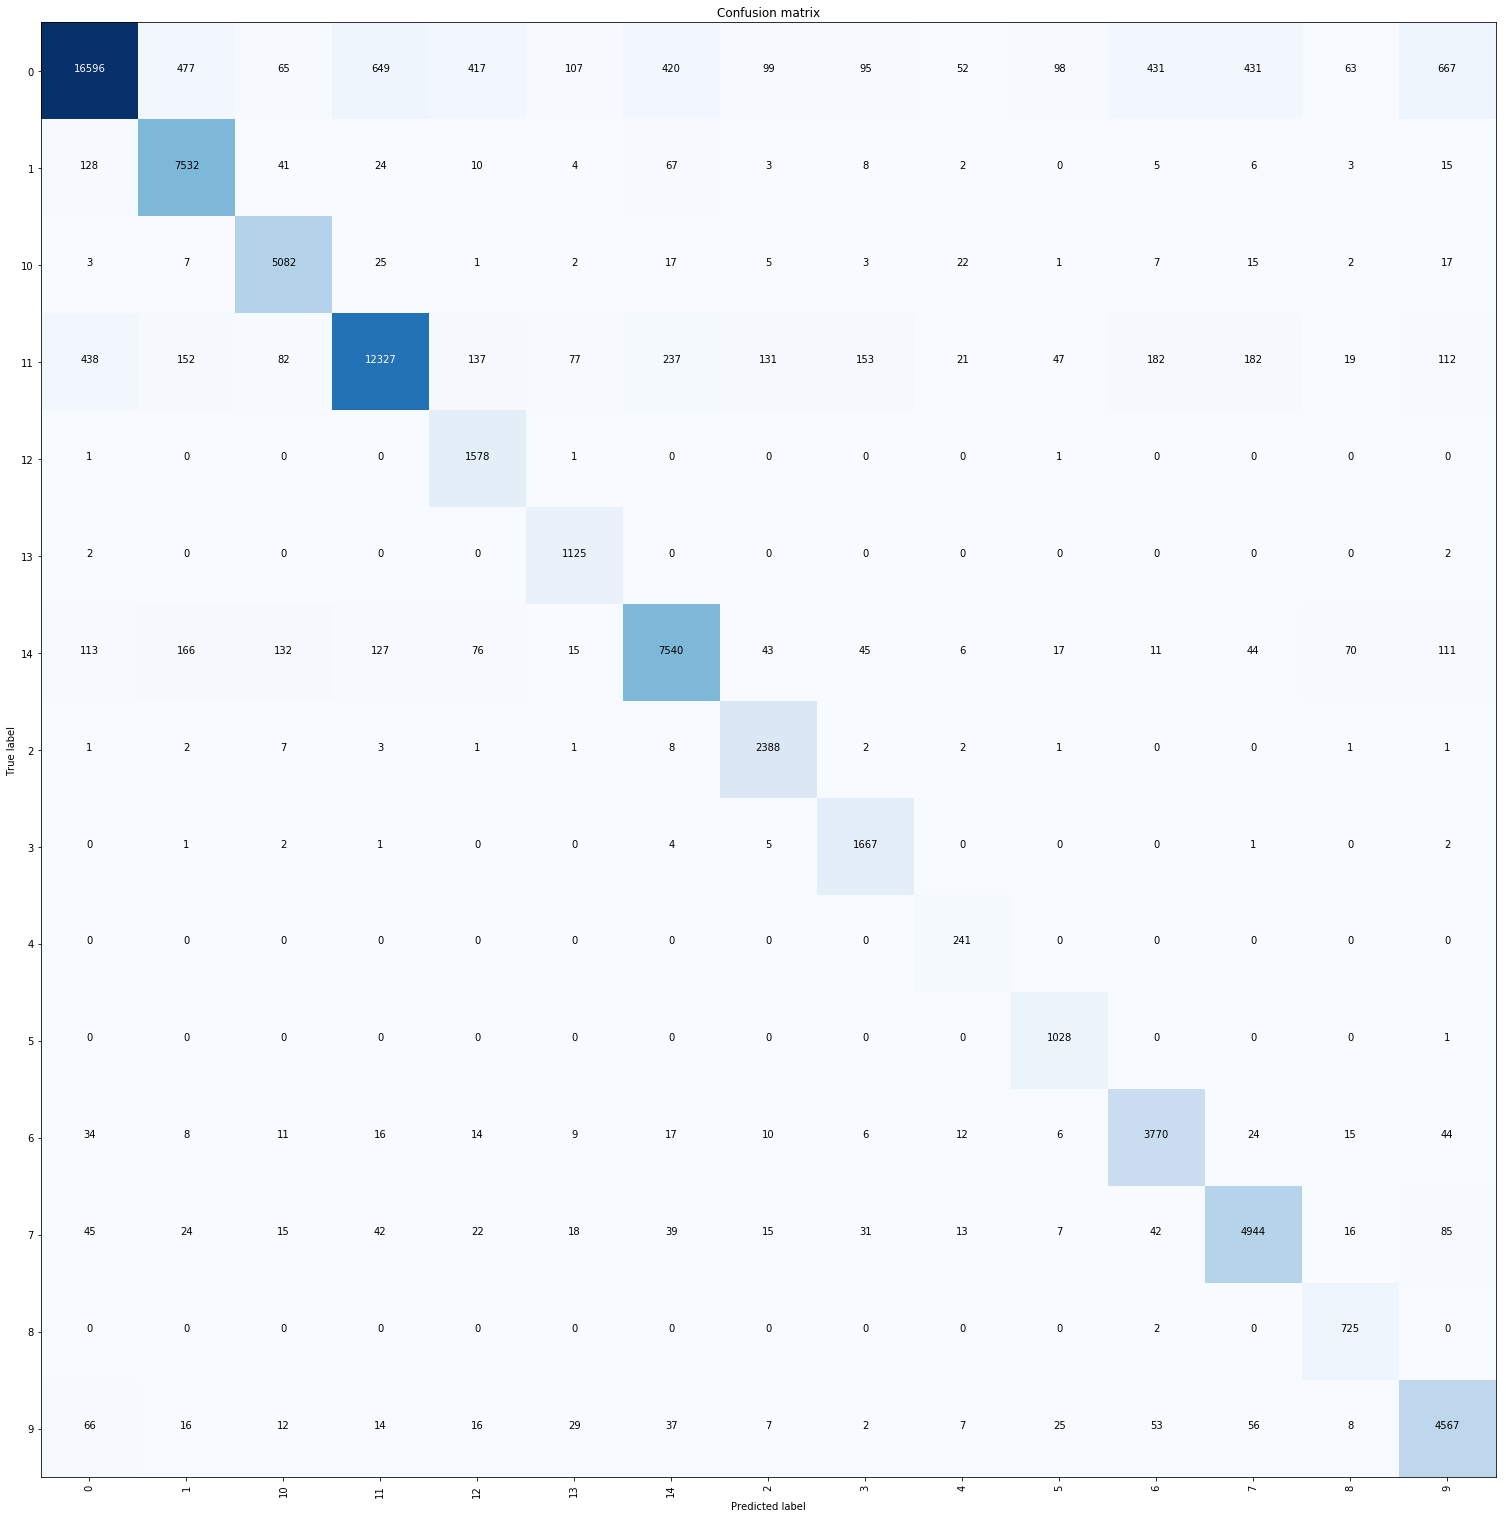


TESTING RESULTS


Accuracy:
0.86
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      4374
           1       0.89      0.94      0.91      1715
          10       0.92      0.97      0.94      1103
          11       0.91      0.84      0.87      3079
          12       0.66      0.93      0.77       364
          13       0.76      0.97      0.85       229
          14       0.87      0.88      0.87      1798
           2       0.86      0.97      0.91       545
           3       0.79      0.96      0.87       355
           4       0.59      1.00      0.74        43
           5       0.82      0.97      0.89       225
           6       0.79      0.86      0.82       846
           7       0.82      0.86      0.84      1169
           8       0.75      0.98      0.85       137
           9       0.75      0.83      0.79      1079

    accuracy                           0.86     17061
   macro avg       0.81      0.92      0.85   

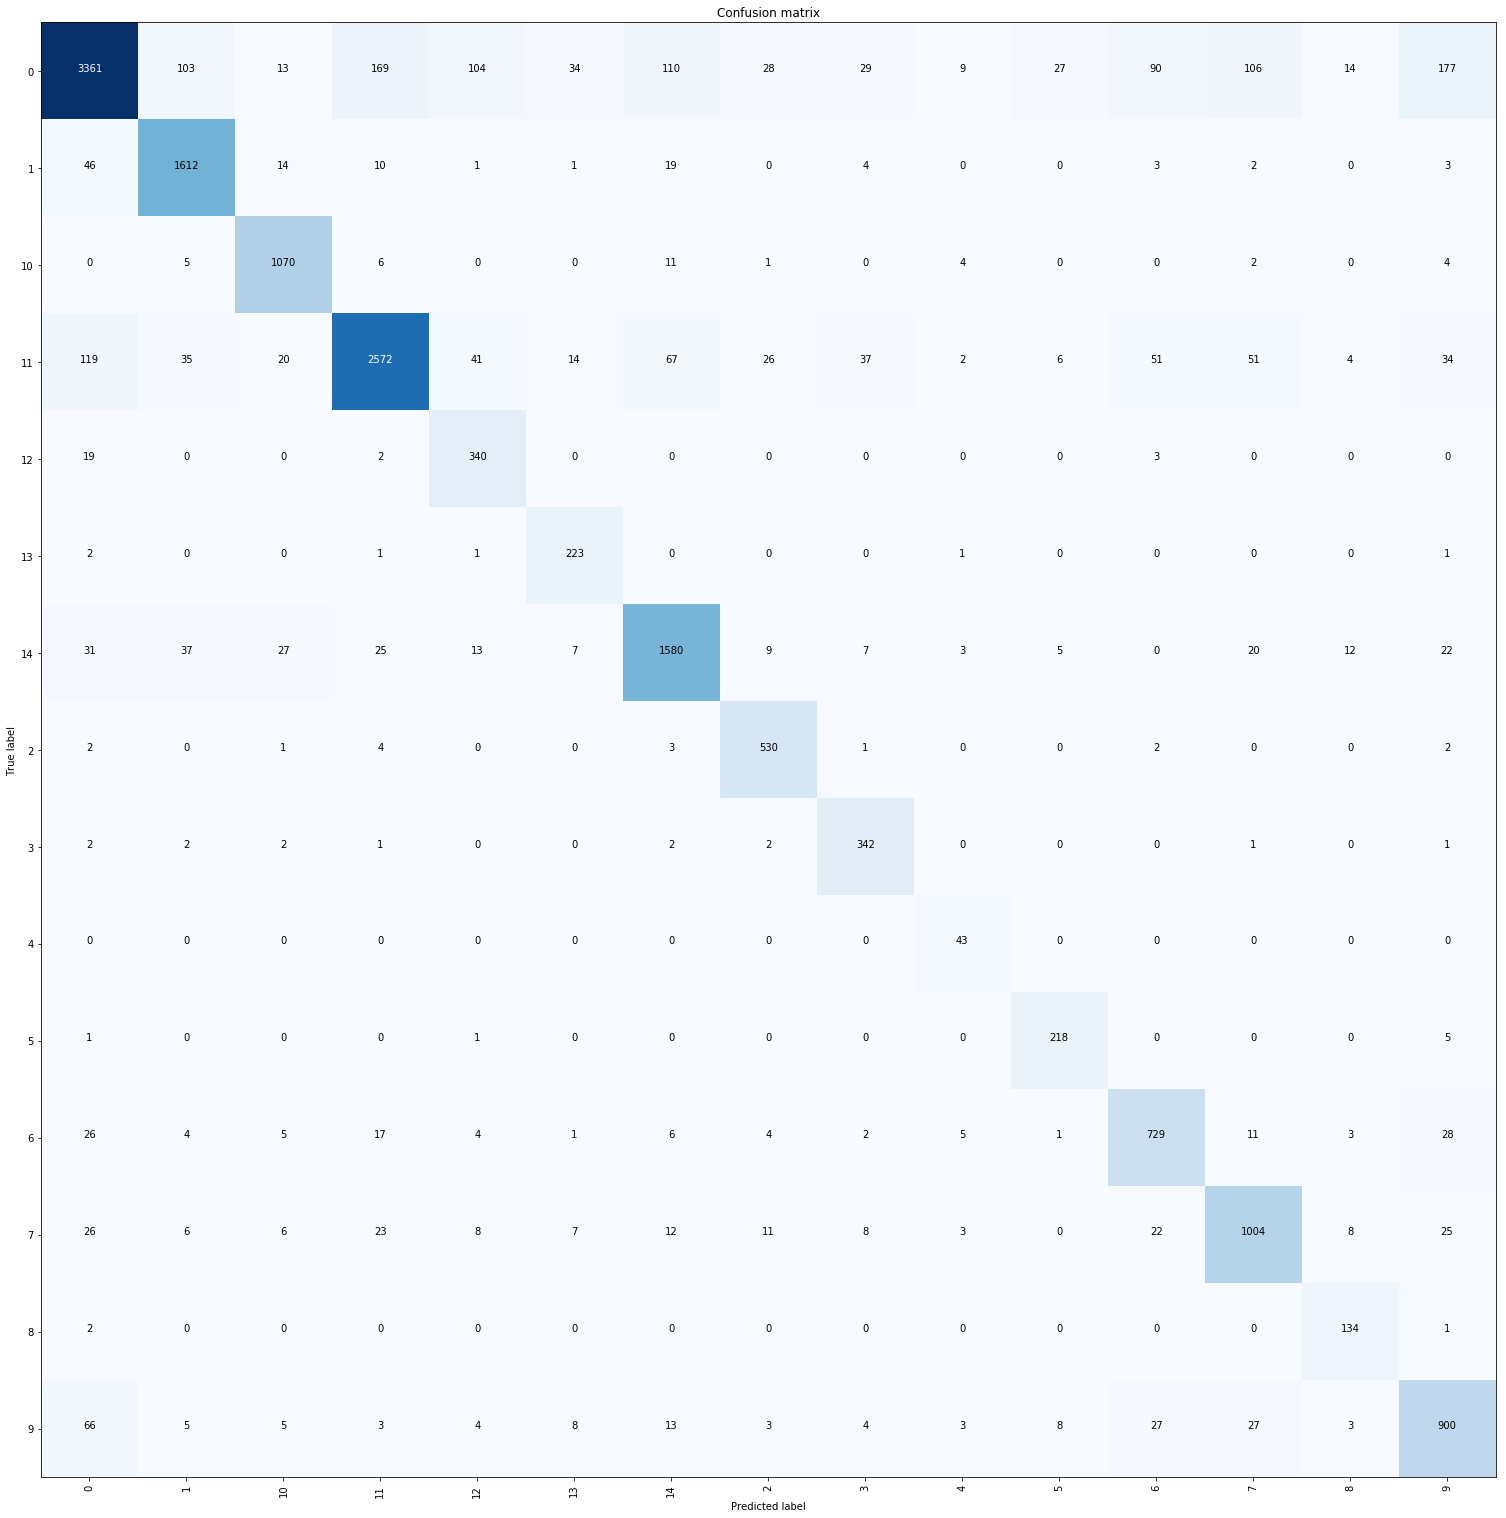

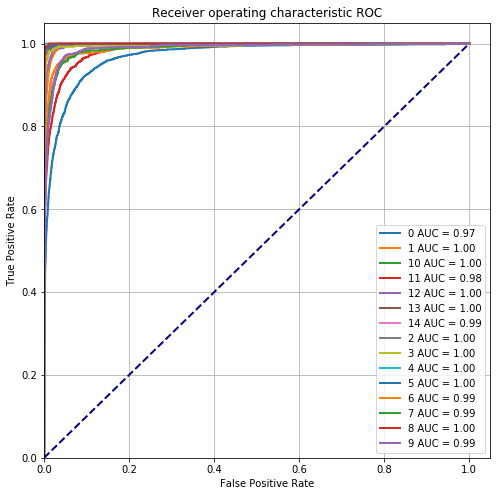

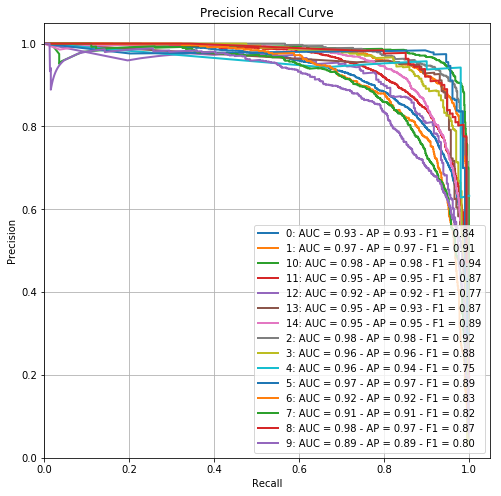


VALIDATION RESULTS

Threshold
[0.16, 0.19, 0.2, 0.17, 0.17, 0.07, 0.12, 0.1, 0.12, 0.3, 0.18, 0.14, 0.17, 0.34, 0.18]


class  false positive rate  true positive rate
0   0     0.092549             0.919340          
1   1     0.026273             0.982371          
2   10    0.009146             0.988139          
3   11    0.062770             0.940038          
4   12    0.020600             0.983380          
5   13    0.011825             0.987013          
6   14    0.050427             0.962162          
7   2     0.011918             0.994350          
8   3     0.012718             0.982097          
9   4     0.001705             1.000000          
10  5     0.005102             0.990148          
11  6     0.042710             0.961407          
12  7     0.041151             0.951881          
13  8     0.002603             0.993506          
14  9     0.048779             0.970238


TESTING RESULTS



class  false positive rate  true positive rate
0   0     0.003626             0.493827          
1   1     0.003845             0.836152          
2   10    0.002068             0.906618          
3   11    0.002289             0.603118          
4   12    0.003354             0.826923          
5   13    0.001961             0.943231          
6   14    0.004652             0.798109          
7   2     0.001756             0.910092          
8   3     0.001856             0.890141          
9   4     0.000588             1.000000          
10  5     0.001485             0.964444          
11  6     0.001912             0.678487          
12  7     0.002139             0.616766          
13  8     0.001418             0.934307          
14  9     0.003066             0.567192

In [47]:
clasifier.fit(cluster_to_train)

In [ ]:
cluster_to_train[:10]

In [ ]:
cluster_to_train.shape

In [ ]:
type(cluster_to_train.label[0])

In [ ]:
data_tmp = cluster_to_train.label == str(2)

In [ ]:
data_tmp[:10]

In [ ]:
i_tmp = 2
for review in cluster_to_train[cluster_to_train.label == str(i_tmp)].iteration.tolist():
    print(review)
    break

Cluster 0


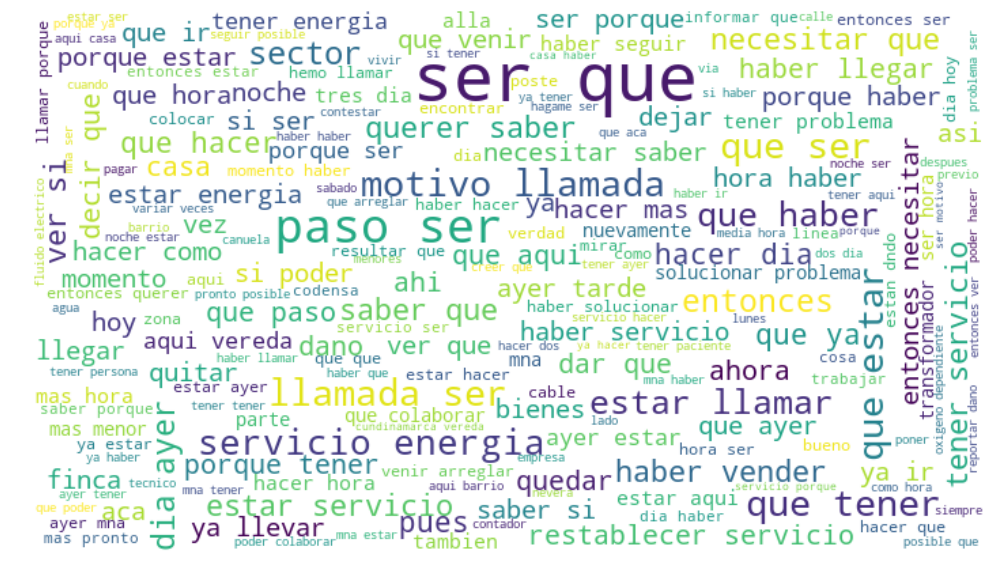

Cluster 1


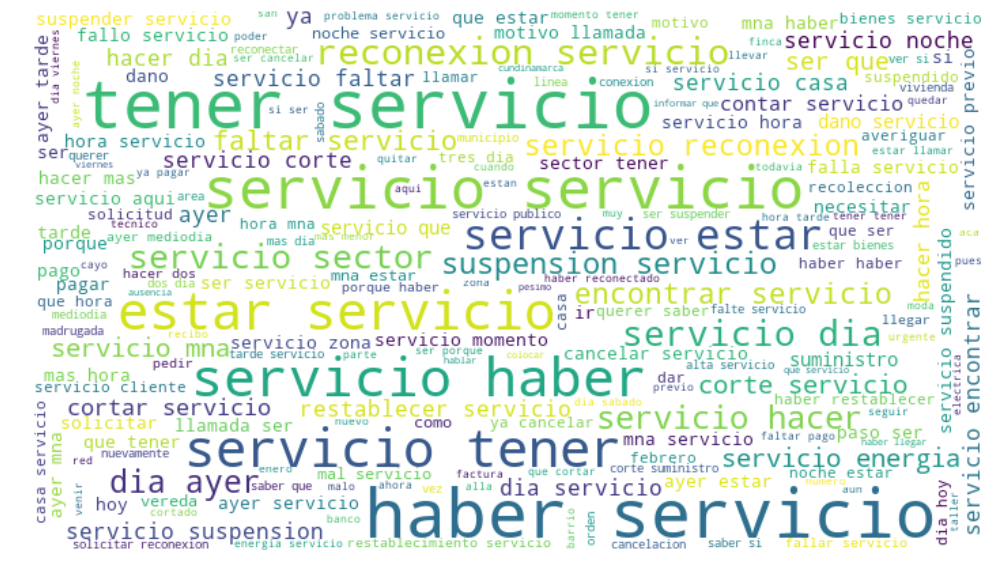

Cluster 2


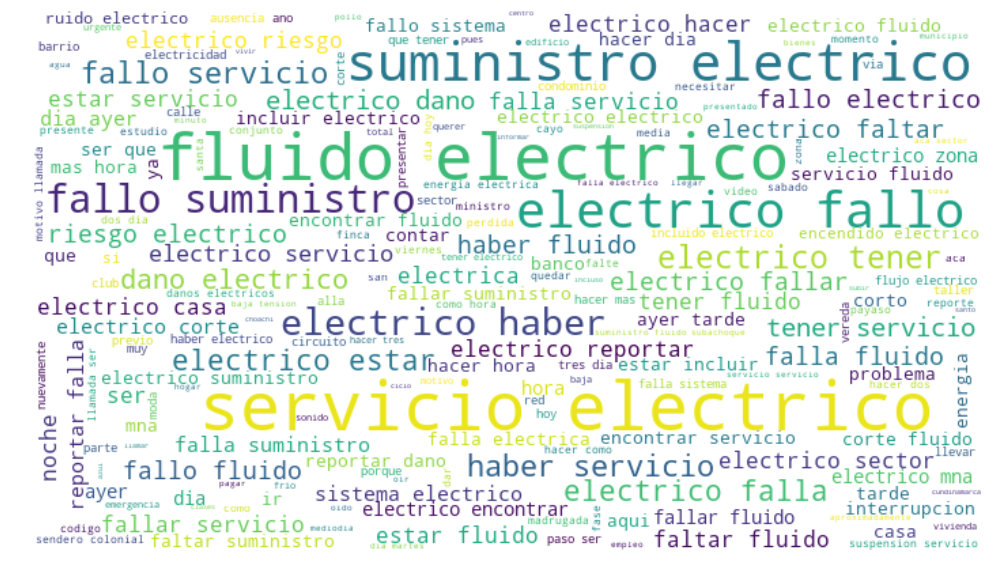

Cluster 3


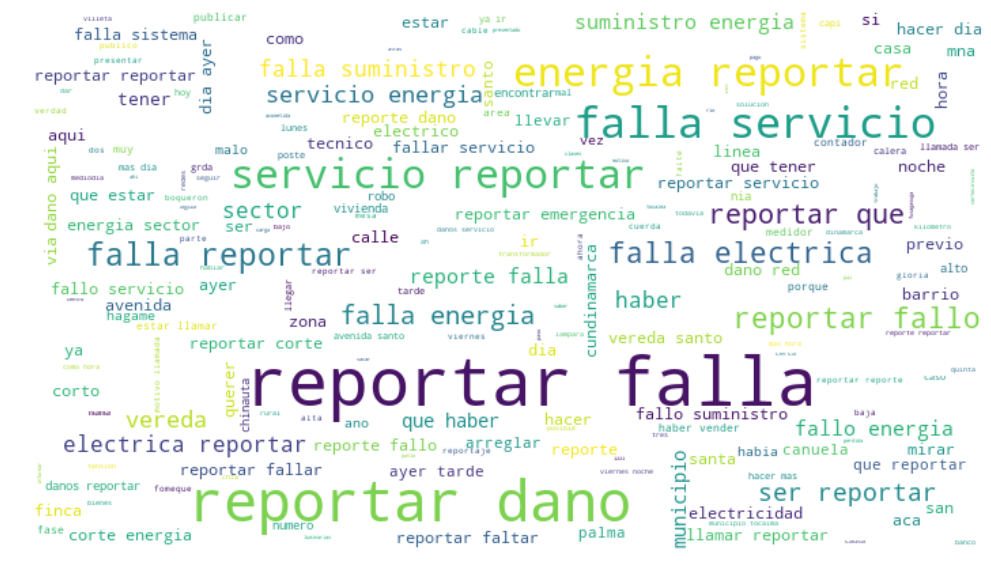

Cluster 4


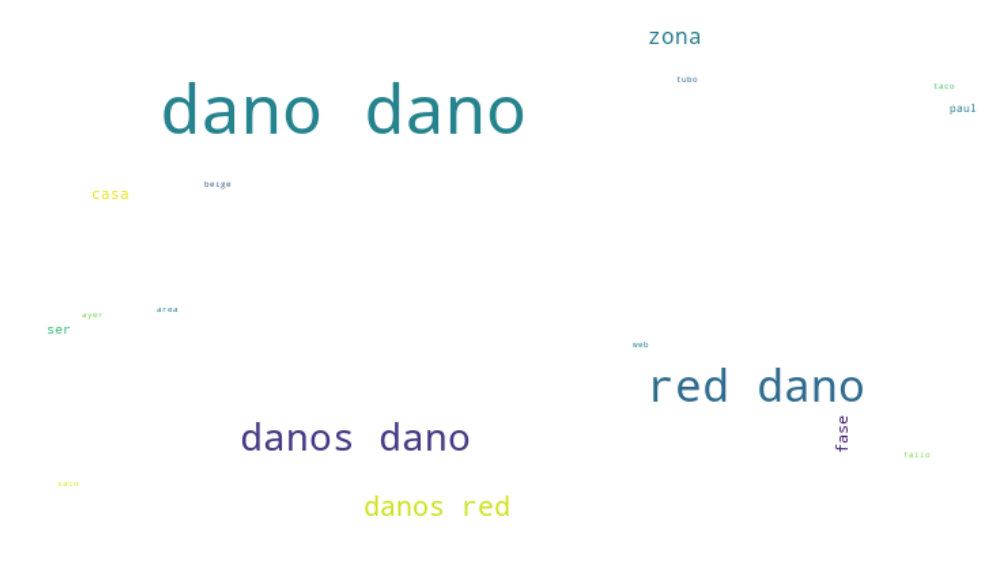

Cluster 5


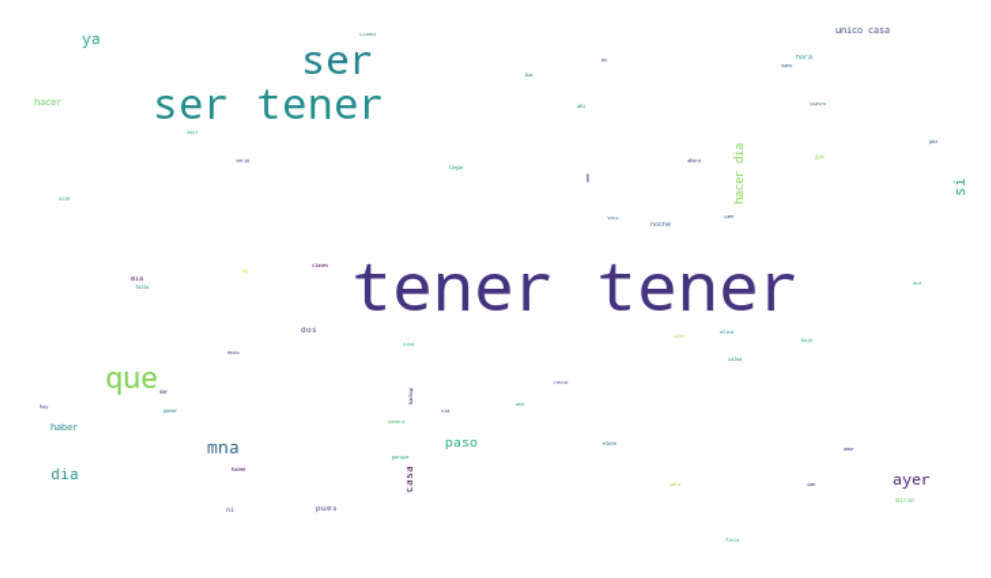

Cluster 6


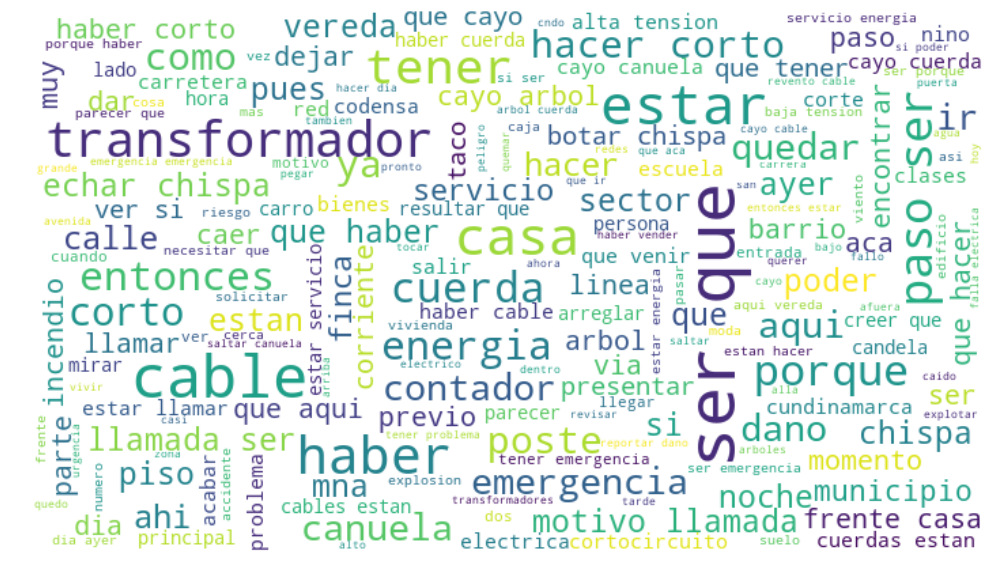

Cluster 7


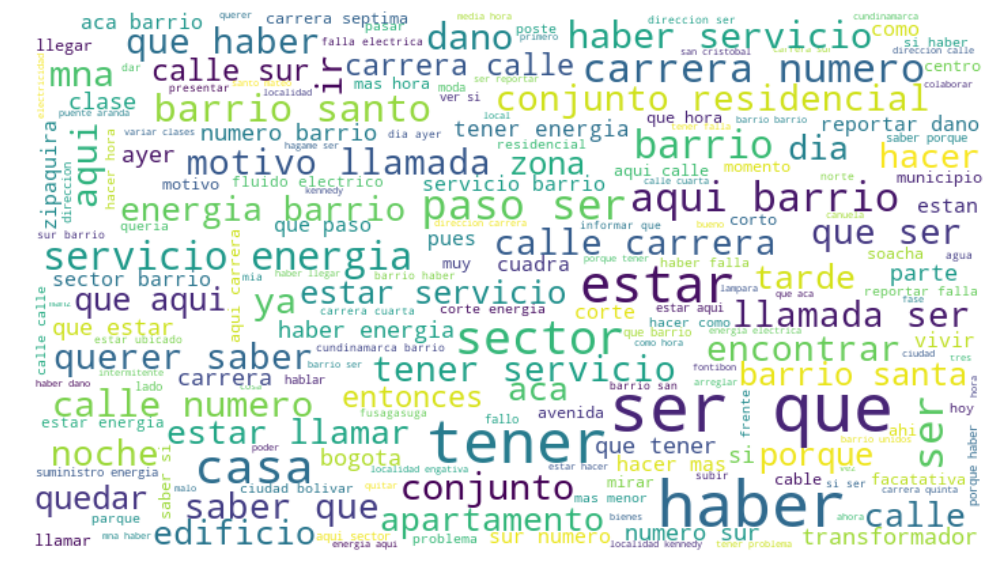

Cluster 8


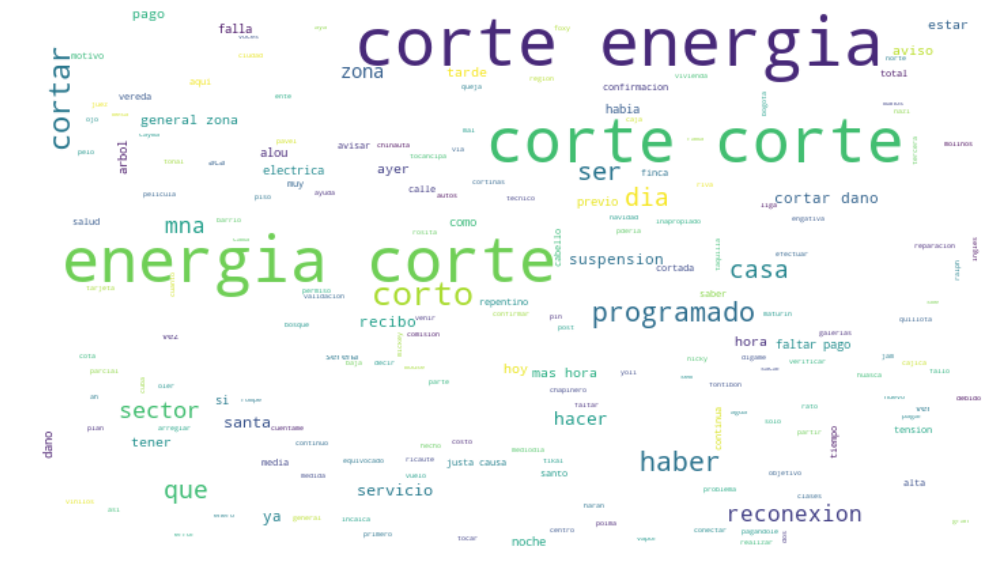

Cluster 9


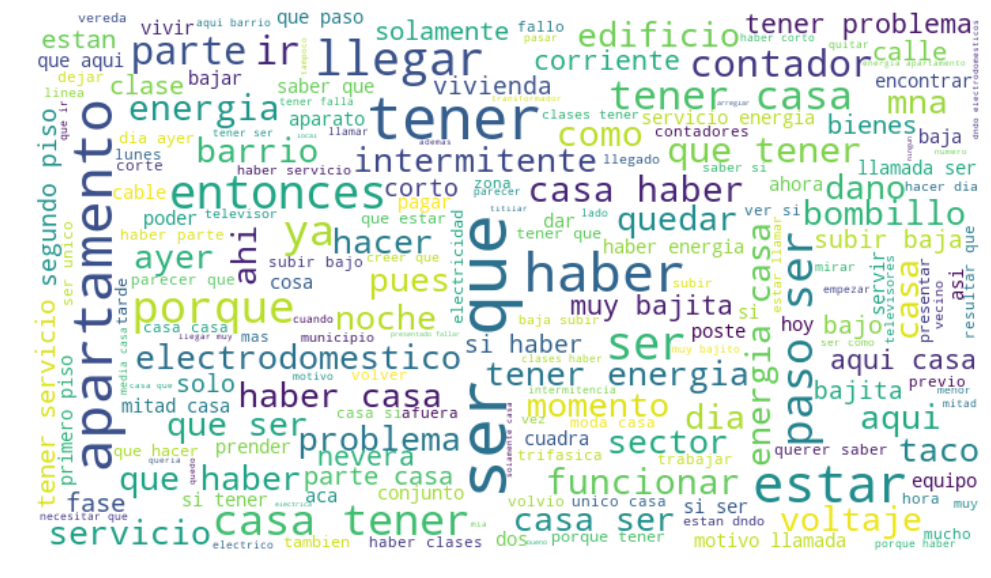

Cluster 10


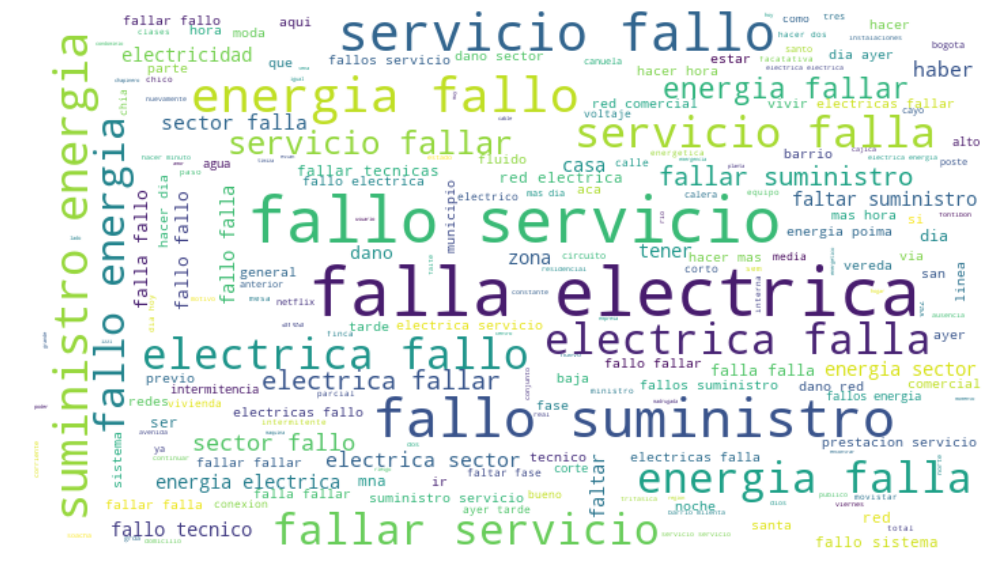

Cluster 11


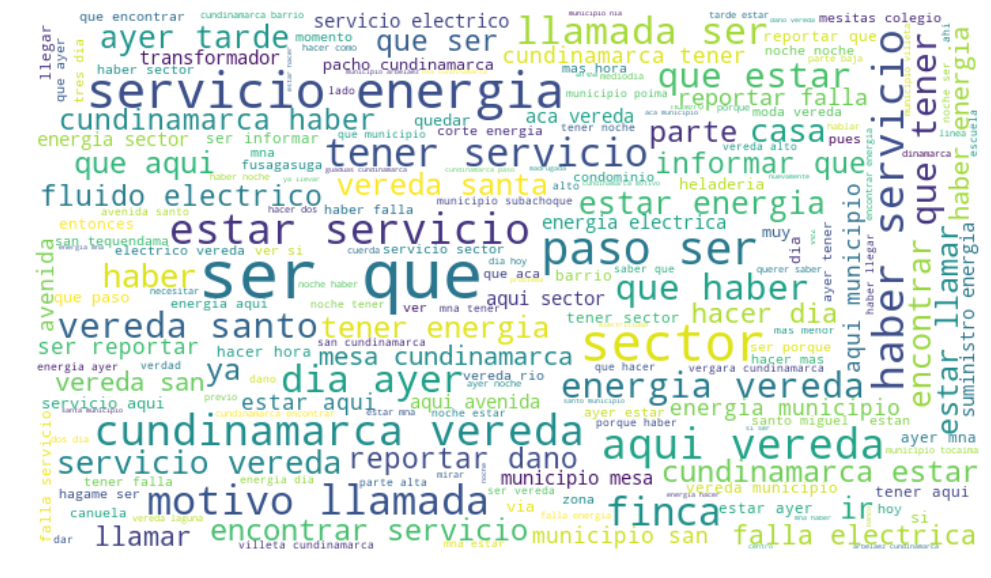

Cluster 12


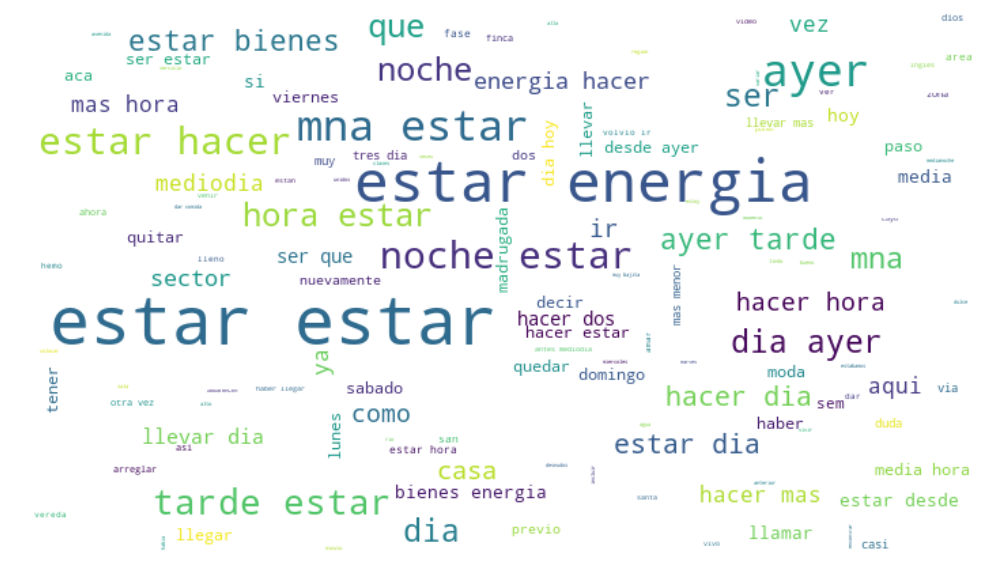

Cluster 13


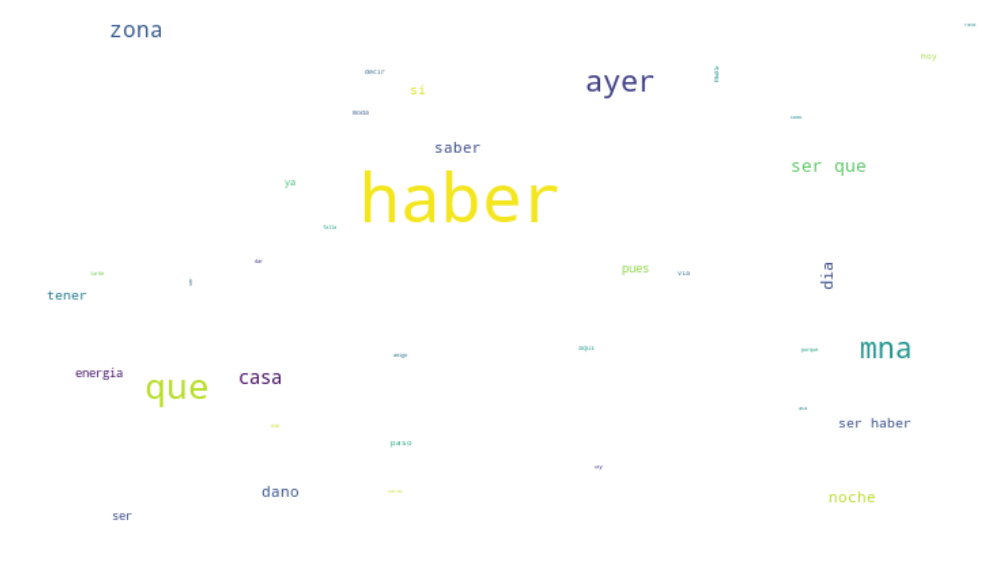

Cluster 14


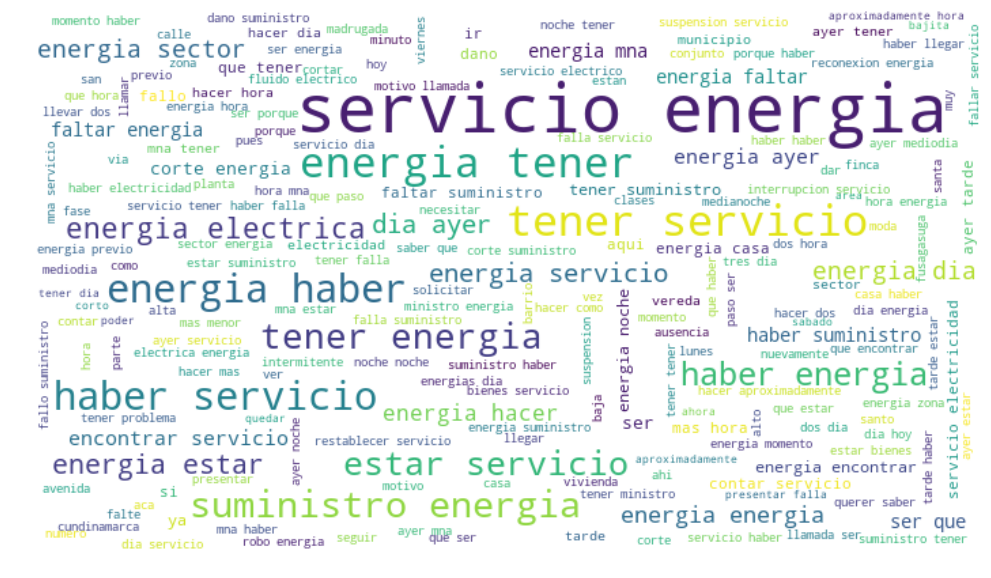

In [48]:
for i in range(cluster_index):
    try:
        print('Cluster {}'.format(i))
        plot_word_cloud(" ".join(review for review in cluster_to_train[cluster_to_train.label == str(i)].iteration.tolist()),str(i))
    except:
        pass

In [49]:
vocab_per_cluster = pd.DataFrame()
for cluster in range(cluster_index):
    try:
        vocab_per_cluster['Cluster {}: Words'.format(cluster)] = vocabulary(clasifier, str(cluster)).feature.tolist()
        vocab_per_cluster['Cluster {}: Coeffs'.format(cluster)] = vocabulary(clasifier, str(cluster))[str(cluster)].tolist()
    except:
        pass
vocab_per_cluster

Cluster 0: Words  Cluster 0: Coeffs    Cluster 1: Words  \
0      necesitar        8.79               servicio             
1      arreglar         6.50               suministro           
2      porque           5.91               reconexion           
3      solucionar       5.90               cancelar             
4      entonces         5.76               suspendido           
...         ...          ...                      ...           
23242  apartamentos    -1.88               barrio               
23243  conjunto        -1.97               servicio electrico   
23244  cuerda          -2.11               reportar             
23245  calle           -2.14               electrico            
23246  carrera         -2.72               energia              

       Cluster 1: Coeffs    Cluster 2: Words  Cluster 2: Coeffs  \
0      22.91              electrico           22.25               
1      4.87               electrica           6.59                
2      4.84               electricos          5.49                
3      3.36               servicio electrico  4.55                
4      3.34               electricidad        3.22                
...     ...                        ...         ...                
23242 -2.88               municipio          -1.39                
23243 -2.95               vereda             -1.39                
23244 -3.01               cundinamarca       -1.47                
23245 -3.55               barrio             -1.51                
23246 -4.91               energia            -1.77                

         Cluster 3: Words  Cluster 3: Coeffs Cluster 4: Words  \
0      reportar            21.11              dano              
1      reporte             10.69              danos             
2      reportar dano       4.63               no                
3      reportar falla      4.33               dano red          
4      reportes            3.89               dano zona         
...         ...             ...                     ...         
23242  tener              -1.71               tener             
23243  cundinamarca       -2.06               no haber          
23244  necesitar reportar -2.48               energia           
23245  electrico          -2.59               electrica         
23246  ser                -2.61               haber             

       Cluster 4: Coeffs   Cluster 5: Words  Cluster 5: Coeffs  \
0      10.24              ser                10.47               
1      9.24               tener              9.57                
2      5.54               no tener           6.31                
3      4.19               sera               3.78                
4      3.96               que ser            3.45                
...     ...                   ...             ...                
23242 -1.30               no tener servicio -2.00                
23243 -1.37               tener servicio    -2.01                
23244 -1.39               energia           -2.17                
23245 -1.49               servicio          -2.28                
23246 -1.79               estar             -2.96                

      Cluster 6: Words  Cluster 6: Coeffs   Cluster 7: Words  \
0      transformador    12.93              barrio              
1      cuerdas          11.15              carrera             
2      cables           10.09              localidad           
3      cable            8.89               conjunto            
4      cuerda           8.23               calle               
...       ...            ...                 ...               
23242  dia             -2.47               dia                 
23243  municipio       -2.50               municipio           
23244  ayer            -2.51               electrodomesticos   
23245  hora            -2.68               servicio            
23246  servicio        -5.57               vereda              

       Cluster 7: Coeffs  Cluster 8: Words  Cluster 8: Coeffs  \
0      16.44

In [50]:
vocab_per_cluster[:100]

Cluster 0: Words  Cluster 0: Coeffs             Cluster 1: Words  \
0   necesitar            8.79               servicio                      
1   arreglar             6.50               suministro                    
2   porque               5.91               reconexion                    
3   solucionar           5.90               cancelar                      
4   entonces             5.76               suspendido                    
5   oxigeno              5.17               tener servicio                
6   que                  4.83               ayer                          
7   colaborar            4.60               no tener servicio             
8   llamar               4.58               suspender                     
9   solucion             4.53               estar servicio                
10  hacer                4.21               suspension                    
11  restablecer          4.08               no haber servicio             
12  tecnico              3.90               haber servicio                
13  persona              3.81               pago                          
14  problema             3.77               corte suministro              
15  colocar              3.49               cortar servicio               
16  esperar              3.42               servicio hacer                
17  querer               3.37               solicitar                     
18  momento              3.34               suspender servicio            
19  poder                3.28               reconexion servicio           
20  estar                3.25               restablecer servicio          
21  contestar            3.24               febrero                       
22  nuevamente           2.94               restablecer                   
23  poner                2.93               servicio sector               
24  codensa              2.86               suspension servicio           
25  quitar               2.74               recoleccion                   
26  ya                   2.74               servicio dia                  
27  posible              2.72               encontrar servicio            
28  estan                2.72               servicio noche                
29  siempre              2.72               corte servicio                
30  llegar               2.72               cortar                        
31  bienes               2.71               dia servicio                  
32  pues                 2.64               factura                       
33  venir                2.62               cancelar servicio             
34  respuesta            2.56               servicio ayer                 
35  urgente              2.56               ser servicio                  
36  volver               2.54               faltar servicio               
37  ahora                2.53               pagar                         
38  hora                 2.53               servicio mna                  
39  nevera               2.53               contar servicio               
40  vender               2.52               no contar servicio            
41  cuando               2.52               servicio hacer hora           
42  empresa              2.49               tener fallar servicio         
43  pasar                2.41               servicio ya                   
44  dependiente          2.40               averiguar                     
45  llamada              2.37               necesitar reportar            
46  tambien              2.35               servicio momento              
47  seguir               2.35               haber falla servicio          
48  radicado             2.28               reconectar                    
49  haber                2.28               servicio no                   
50  tiempo               2.22               hora                          
51  ningun               2.22               hora servicio                 
52  paciente             2.21   

In [ ]:
for label_test in range(cluster_index):
    foldername = 'with_stopwords_no_names/cluster_{}'.format(label_test)
    if not os.path.exists(foldername):
        os.makedirs(foldername)
    for idx_feature in range(10):
        graph = create_adjacency_graph(data_set = cluster_to_train,
                                       model = clasifier,
                                       label = str(label_test),
                                       num_features = idx_feature,
                                       per_class = True,
                                       levels = 2)
        filename = os.path.join(foldername, 'cluster_{}_feature_{}'.format(label_test, idx_feature))
        graph.render(filename)

In [54]:
'''
idx_ = 11
graph = create_adjacency_graph(data_set = cluster_to_train,
                               model = clasifier,
                               label = str(idx_),
                               num_features = 5,
                               per_class = True,
                               levels = 2)
graph.render('test_render_{}_V{}'.format(idx_, num_features))
'''

'test_render_11_V4.pdf'

In [51]:
vocab_per_cluster[['Cluster {}: Words'.format(x) for x in range(cluster_index)]][:20]

Cluster 0: Words     Cluster 1: Words           Cluster 2: Words  \
0   necesitar        servicio             electrico                   
1   arreglar         suministro           electrica                   
2   porque           reconexion           electricos                  
3   solucionar       cancelar             servicio electrico          
4   entonces         suspendido           electricidad                
5   oxigeno          tener servicio       fluido electrico            
6   que              ayer                 suministro electrico        
7   colaborar        no tener servicio    fluido                      
8   llamar           suspender            electricas                  
9   solucion         estar servicio       danos electricos            
10  hacer            suspension           electrica falla electrica   
11  restablecer      no haber servicio    electrica falla             
12  tecnico          haber servicio       club                        
13  persona          pago                 electrica ser               
14  problema         corte suministro     electrico hacer             
15  colocar          cortar servicio      fallo                       
16  esperar          servicio hacer       no tener                    
17  querer           solicitar            dano electrico              
18  momento          suspender servicio   riesgo electrico            
19  poder            reconexion servicio  ausencia                    

   Cluster 3: Words Cluster 4: Words  Cluster 5: Words Cluster 6: Words  \
0   reportar         dano             ser               transformador     
1   reporte          danos            tener             cuerdas           
2   reportar dano    no               no tener          cables            
3   reportar falla   dano red         sera              cable             
4   reportes         dano zona        que ser           cuerda            
5   reportaje        dano casa        dia no tener      emergencia        
6   reportar que     red              dia no            canuelas          
7   reportar fallo   dano fase        vez ser           chispas           
8   reporte falla    tubo             no                canuela           
9   falla            dano area        ayer no tener     contador          
10  reportado        danos red        no ser            poste             
11  ano              fase             casa no tener     arbol             
12  reportar que no  ser dano         no no dar         peligro           
13  sector energia   zona             mna ser           corto             
14  reporte fallo    fallo            como ser          incendio          
15  reporte dano     dano dano        ano ser           cortocircuito     
16  reportar corte   danos danos      mna no tener      tension           
17  energia          area             tener casa tener  transformadores   
18  recortar         taco             que no tener      cayo              
19  presentar dano   casa             ayer no           candela           

   Cluster 7: Words Cluster 8: Words   Cluster 9: Words  Cluster 10: Words  \
0   barrio           corte            apartamento        falla               
1   carrera          cortar           electrodomesticos  fallar              
2   localidad        corto            casa               fallo               
3   conjunto         corto energia    intermitente       faltar              
4   calle            cortar dano      clases             fallos              
5   numero           corto ser        prender            fallo servicio      
6   residencial      cortar energia   funcionar          sector              
7   soacha           cortada          apartamentos       fallar servicio     
8   facatativa       muy              corriente          dano sector         
9   zipaquira        corte no         bombillos          falla electrica     
10  direccion        oler             contador           fallo energia       

In [48]:
cluster_to_train[:10]

_text  \
0                                    no hay servicio   
1  escorpion corte de energia desde las 8 de la m...   
2  estoy llamando la Vereda campo municipal capar...   
3  y casi todos los dias estamos sin luz en el pr...   
4  hay muchos cortes de energia constantes bajone...   
5                                     no hay energia   
6                             problemas del servicio   
7                                       corte de luz   
8  lo que pasa es que tengo un problema con la va...   
9                               falla en el servicio   

                                           iteration label  
0                                  no haber servicio     8  
1  escorpion corte energia manana ser manana solu...    11  
2  estar llamar vereda campo municipal caparrapi ...     7  
3   casi dia estar luz primero ser hora ahora vez no    11  
4  haber cortes energia constantes bajones luz po...    11  
5                                   no haber energia     3  
6                                  problema servicio     8  
7                                          corte luz     5  
8  paso ser que tener problema vaina energia hace...    11  
9                                     fallo servicio     9

In [95]:
count_elems_in_cluster = cluster_data['ClusterNumber'].value_counts().to_frame()
count_elems_in_cluster

ClusterNumber
11          28632
7           21643
6           11908
8           11796
3           10684
1            8152
9            7566
10           3926
0            3592
4            2335
2            2154
5            1400

In [103]:
count_elems_in_cluster.loc[11, 'ClusterNumber']

numpy.int64

In [130]:
total_num = count_elems_in_cluster.loc[:, 'ClusterNumber'].sum()
for i in range(cluster_index):
    num_i = count_elems_in_cluster.loc[i, 'ClusterNumber']
    print('Cluster {}: {}/{} -> {}'.format(i, num_i, total_num, float(num_i)/total_num * 100))

Cluster 0: 3592/113788 -> 3.156747635954582
Cluster 1: 8152/113788 -> 7.164200091398039
Cluster 2: 2154/113788 -> 1.892993988821317
Cluster 3: 10684/113788 -> 9.389390796920589
Cluster 4: 2335/113788 -> 2.0520617288290506
Cluster 5: 1400/113788 -> 1.23035821000457
Cluster 6: 11908/113788 -> 10.465075403381729
Cluster 7: 21643/113788 -> 19.02045909937779
Cluster 8: 11796/113788 -> 10.366646746581361
Cluster 9: 7566/113788 -> 6.64920729778184
Cluster 10: 3926/113788 -> 3.450275951769958
Cluster 11: 28632/113788 -> 25.162583049179176


113788

In [61]:
tmp_cluster_to_train = cluster_to_train

In [62]:
tmp_cluster_to_train.shape

(113737, 3)

In [207]:
data_validate = tmp_cluster_to_train[tmp_cluster_to_train['label'] == str(11)]

In [208]:
data_validate[:5]

_text  \
1   escorpion corte de energia desde las 8 de la m...   
3   y casi todos los dias estamos sin luz en el pr...   
4   hay muchos cortes de energia constantes bajone...   
8   lo que pasa es que tengo un problema con la va...   
10  no tenemos servicio de energia en la Vereda oz...   

                                            iteration label  
1   escorpion corte energia manana ser manana solu...    11  
3    casi dia estar luz primero ser hora ahora vez no    11  
4   haber cortes energia constantes bajones luz po...    11  
8   paso ser que tener problema vaina energia hace...    11  
10  no tener servicio energia vereda ozuna no no c...    11

In [209]:
cluster_11_text = data_validate.loc[:, '_text'].tolist()

In [211]:
counter = 0
for idx, text in enumerate(cluster_11_text):
    if idx > 10:
        print(text)
        print('---------')
        counter += 1
    if counter > 11:
        break

que desde esta manana a las 10:00 de la manana Se fue la luz en en unas casas y en otras no y yo uso de oxigeno 24 horas y estoy ahogada y no tengo como irme a aprender oxigeno en otro lado ,  Que tengo que hacer ante eso senor
---------
no tio la llamada Es que estamos sin luz en accion hms cortaron la luz y no hablando despues te habian dicho que 15 dias venian y no la han colocado
---------
desde el 1deg de enero no tengo servicio de Electricidad se saca una muela Si esta al lado carretera o sea es que suban y suban la canela ya no esta demorado se me hace incomodo que usted no yo mando por este servicio de a tres dias y no me soluciona nada
---------
y hagame un favor Es que yo desde primero sin servicio de Electricidad y necesito que me solucione porque tengo una persona con oxigeno que tiene que usar oxigeno todo el dia Ya la pipeta se me acabo y es una canuela esta ahi en toda la calle en toda la entrada de la calle Ahi esta la calle la calle 3 y me puedan solucionar algo Porque

In [64]:
cluster_grouped = cluster_to_train

In [69]:
type(cluster_grouped)

pandas.core.frame.DataFrame

In [71]:
cluster_grouped.loc[(cluster_to_train['label'] == str(11)) , 'label']

1         11
3         11
4         11
8         11
10        11
          ..
113762    11
113763    11
113771    11
113777    11
113778    11
Name: label, Length: 28632, dtype: object